## Project 2

## <em> Fourier methods, Matched Filtering, and Differential Equations</em>
<br>
This notebook is arranged in cells. Texts are usually written in the markdown cells, and here you can use html tags (make it bold, italic, colored, etc). You can double click on this cell to see the formatting.<br>
<br>
The ellipsis (...) are provided where you are expected to write your solution but feel free to change the template (not over much) in case this style is not to your taste. <br>
<br>
<em>Hit "Shift-Enter" on a code cell to evaluate it.  Double click a Markdown cell to edit. </em><br>

<span style="color:blue"><i> Write your partner's name here (if you have one). </i></span> <br>

***
### Link Okpy

In [ ]:
from client.api.notebook import Notebook
ok = Notebook('project2.ok')
_ = ok.auth(inline = True)

### Imports

In [1]:
import numpy as np
import json
from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz
from IPython.display import Audio
from scipy.io import wavfile
import h5py
import matplotlib.mlab as mlab
#For plotting
import matplotlib.pyplot as plt
%matplotlib inline

***

#### Problem - LIGO Gravitational Wave Detection

On February 11 2016, the LIGO (Laser Interferometer Gravitational-wave Observatory) and Virgo collaboration announced the first observation of gravitational waves from the collision and merger of a pair of black holes. Such observation was made on 14 September 2015 by the two detectors of the LIGO (Hanford and Livington); hence, the signal was named "GW150914." This event took place in a distant galaxy more than one billion light years from the Earth. LIGO estimated that the peak gravitational-wave power radiated during the final moments of the black hole merger was more than ten times greater than the combined light power from all the stars and galaxies in the observable Universe. This remarkable discovery marks the beginning of an exciting new era of astronomy as we open an entirely new, gravitational-wave, window on the Universe. The 2017 Nobel Prize was awarded to researchers of the LIGO/Virgo collaboration for such discovery (https://www.nobelprize.org/nobel_prizes/physics/laureates/2017/press.html).
<br><br>
Gravitational waves are "ripples" in space-time produced by some of the most violent events in the cosmos, such as the collisions and mergers of massive compact stars. Their existence was predicted by Einstein in 1916, when he showed that accelerating massive objects would shake space-time so much that waves of distorted space would radiate from the source. 
<br><br>
In the same year that Einstein predicted gravitational waves, the physicist Karl Schwarzschild showed that Einstein's work permitted the existence of black holes. There have been dramatic improvements in our theoretical understanding of these bizarre objects - including, over the past decade, some remarkable advances in modeling a pair of black holes (referred to as a binary) through several close orbits before they finally merge. These computer models have allowed us to construct precise gravitational waveforms - i.e. the pattern of gravitational waves emitted by the black holes as they approach ever closer and finally merge into a single, larger black hole - in accordance with the predictions of general relativity. The direct observation of a binary black hole merger would therefore provide a powerful cosmic laboratory for testing Einstein's theory.
<br><br>
<img src="BHmerger.png" width="450" height="450" />
<br><br>
The above image shows the predictions of the best-matching waveform computed from general relativity, over the three stages of the event: inspiral, merger and ringdown. A visual simulation is available here: http://www.glowscript.org/#/user/rhilborn/folder/Public/program/BinaryInSpiral
<br><br>
LIGO comprised of two giant laser interferometers located thousands of kilometers apart, one in Livingston, Louisiana and the other in Hanford, Washington. As shown in the below simplified diagram, an interferometer like LIGO consists of two "arms" (each one 4km long) at right angles to each other, along which a laser beam is shone and reflected by mirrors (suspended as test masses) at each end. When a gravitational wave passes by, the stretching and squashing of space causes the arms of the interferometer alternately to lengthen and shrink, one getting longer while the other gets shorter and then vice-versa. As the interferometers' arms change lengths, the laser beams take a different time to travel through the arms - which means that the two beams are no longer "in step" (or in phase) and what we call an interference pattern is produced. This is why we refer to the LIGO detectors as "interferometers".
<br><br>
<img src="LIGO_detector.png" width="600" height="600" />
<br><br>
The difference between the two arm lengths is proportional to the strength of the passing gravitational wave, referred to as the <b>gravitational-wave strain</b>, and this number is mind-bogglingly small. For a gravitational wave typical of what we can detect, we expect the strain to be about 1/10,000th the width of a proton! However LIGO's interferometers are so sensitive that they can measure even such tiny amounts.
<br><br>
In Project 2, we take the strain data from LIGO and use matched filtering to find hidden signals from noisy data. Ultimately, we aim to show that the waveform detected by LIGO matched the predictions of general relativity, confirming that LIGO has detected gravitational waves.
<br><br>
First, load the data from LIGO Hanford's <b>H1</b> detector and Livingston's <b>L1</b> detector.
<br><br>
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;  Reference: http://www.ligo.org/science/Publication-GW150914/

In [2]:
# Load data
events = json.load(open("BBH_events_v3.json","r"))
event = events['GW150914']

In [3]:
# Module for reading LIGO data files
import readligo as rl

In [4]:
# H1 data
# "strain_H1" is a vector of strain values
# "time_H1" is a vector of time values to match the strain vector
# chan_dic_H1 is a dictionary of data quality channels. Ignore this. 
fn_H1 = event['fn_H1']
strain_H1, time, chan_dict_H1 = rl.loaddata(fn_H1, 'H1')

# L1 data
fn_L1 = event['fn_L1']
strain_L1, time, chan_dict_L1 = rl.loaddata(fn_L1, 'L1')

# Approximate time of a binary black hole merger (Mon Sep 14 09:50:45 GMT 2015 )
tevent = event['tevent'] - time[0]

# Time since 9:50:29 GMT 2015
time = time - time[0]
tevent = tevent - time[0]

# Template waveform
fn_template = event['fn_template']

# Sampling rate
fs = event['fs']

# frequency band for bandpassing signal
fband = event['fband']

We define the vector "time" as the time since Sep 14 9:50:29 GMT 2015. The event of a binary black hole merger occurred around Sep 14 09:50:45 GMT 2015 ("tevent" - about 16s after time[0]). The strain values of H1 and L1 detectors are stored as "strain_H1" and "strain_L1" respectively.
<br><br>
<span style="color:blue"> <i> 1. Plot the time strain data for both H1 and L1. Mark the event of a merger on the plot.  </i></span> <br>

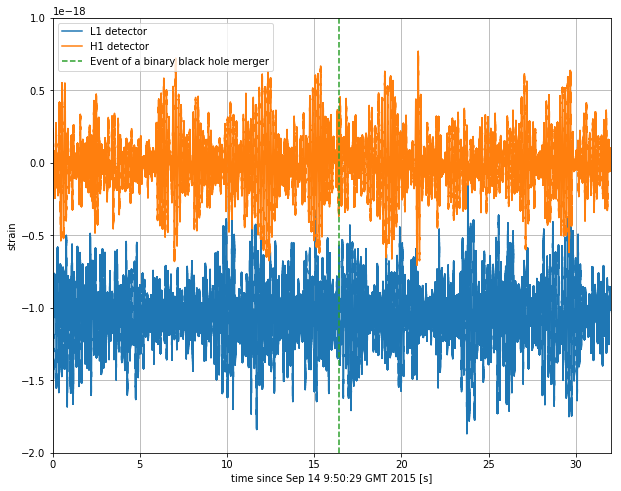

In [5]:
plt.figure(figsize=(10,8))
plt.plot(time,strain_L1, label = 'L1 detector')
plt.plot(time,strain_H1, label = 'H1 detector')
plt.plot(tevent*np.ones(2), [-2.0e-18, 1.e-18], '--', label = 'Event of a binary black hole merger')

plt.xlim(time[0], time[-1]); plt.ylim(-2.0e-18, 1.e-18)
plt.xlabel('time since Sep 14 9:50:29 GMT 2015 [s]'); plt.ylabel('strain')
plt.grid('on')
plt.legend()
plt.show()

<br><br>
The FFT $y[k]$ of length $N$ of the length-$N$ sequence $x[n]$ is defined as
<img src="fft1.png" width="200" height="100" />
and the inverse transform is defined as follows
<img src="fft2.png" width="200" height="100" />
<br><br>
These transforms can be calculated by means of np.fft.fft (np.fft.rfft) and np.fft.ifft. (https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.fft.html)
<br><br>
From the definition of the FFT it can be seen that
<br><br>
<img src="fft3.png" width="150" height="75" />
<br><br>
For $N$ even, the elements $y[1]...y[N/2−1]$ contain the positive-frequency terms, and the elements $y[N/2]...y[N−1]$ contain the negative-frequency terms, in order of decreasingly negative frequency. For $N$ odd, the elements $y[1]...y[(N−1)/2]$ contain the positive-frequency terms, and the elements $y[(N+1)/2]...y[N−1]$ contain the negative-frequency terms, in order of decreasingly negative frequency.
<br><br>
In case the sequence x is real-valued, the values of $y[n]$ for positive frequencies is the conjugate of the values y[n] for negative frequencies (because the spectrum is symmetric). Typically, only the FFT corresponding to positive frequencies is plotted.
<br><br>
np.fft.fft gives $y[0],y[1]...y[N-1]$ while np.fft.rfft gives $y[0],y[1]...y[N/2−1]$ (real FFT).
<br><br>
Now, let us plot the FFT of the sum of two sines as an example.

In [6]:
# Number of samples
N = 600
# sampling rate
fs_example = 800.0
# sample spacing
dt_example = 1.0 / fs_example

t = (1 / fs_example * np.arange(N))

Using $N = 600$ samples with the sample rate $f_s = 800$, assume that $t$ runs from $0$ to $N/f_s$.
<br><br>
We define the sum of two sines as:
$$ f(t) = a_1 \mathrm{sin}(2\pi w_1 t) + a_2 \mathrm{sin}(2\pi w_2 t) $$
<br> where $a_1 = 0.5, a_2 = 1.6, w_1 = 50, w_2 = 130$.
<br><br>
<b>1. Using np.fft.rfft:</b><br>
Now, compute the FFT of $f(t)$ by doing np.fft.rfft(f(t)). Then, take the absolute value of it and then multiply by a normalization factor $2/N$. 
<br><br>
You can get the frequency using np.fft.rfftfreq.
<br><br>
<b>2. Using np.fft.fft:</b><br>
Similarly, compute the FFT of $f(t)$ by doing np.fft.fft(f(t)) and take the absolute value of it and then multiply by a normalization factor $2/N$. You can also get the frequency using np.fft.fftfreq.
<br><br>
Now, select the first $N/2$ values in order to only plot the positive-frequency terms. 
<br><br>
<span style="color:blue"> <i> 2. Plot the FFT of $f(t)$ using both np.fft.rfft and np.fft.fft.  </i></span> <br>

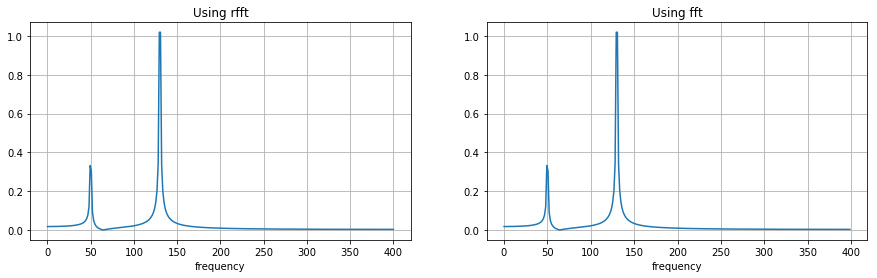

In [7]:
# Define f(t)
def f(t, a1, a2, w1, w2):
    return a1*np.sin(2.0*np.pi*w1*t) + a2*np.sin(2.0*np.pi*w2*t)
    
y = f(t, 0.5, 1.6, 50, 130)

# Use rfft
norm = 2.0/N
yf = np.fft.rfft(y)
abs_yf = norm*np.abs(yf)

xf = np.fft.rfftfreq(len(y), d = 1./fs_example)


fig, axes = plt.subplots(1,2,figsize=(15,4))
ax = axes[0]
ax.plot(xf, abs_yf)
ax.set_xlabel('frequency')
ax.grid(); ax.set_title("Using rfft")

# Use fft
norm = 2.0/N
yf = np.fft.fft(y)
abs_yf = norm*np.abs(yf)

xf = np.fft.fftfreq(len(y), d = 1./fs_example)

ax = axes[1]
plt.plot(xf[0:N//2], abs_yf[0:N//2])
ax.set_xlabel('frequency')
ax.grid(); ax.set_title("Using fft")

plt.show()

Now, transform back to the time domain. Let yf = np.fft.rfft(f(t)). Then, you can find the inverse FFT by doing np.fft.irfft(yf, len(f(t))). 
<br><br>
<span style="color:blue"> <i> Plot the inverse FFT of yf (equivalent to ploting $f(t)$ vs. $t$).  </i></span> <br>

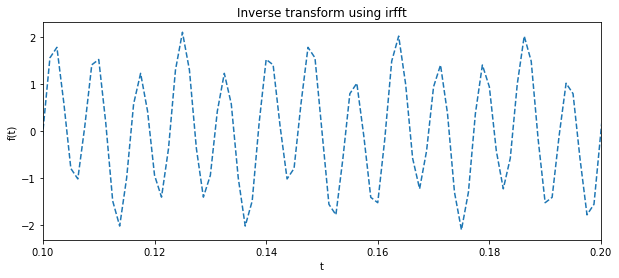

In [8]:
y = f(t, 0.5, 1.6, 50, 130)
yf = np.fft.rfft(y)
y_inv = np.fft.irfft(yf, len(y))

plt.figure(figsize = (10,4))

plt.plot(t, y_inv, '--')
plt.xlabel('t'); plt.ylabel('f(t)')
plt.xlim(0.1, 0.2); plt.title("Inverse transform using irfft")
plt.show()


<span style="color:blue"> <i> 3. For LIGO strain data, $f_s = 4096$ Hz. Let $N = 4f_s$. Do the FFT of the H1 strain data using "np.fft.rfft" (compute the FFT of the strain data by doing np.fft.rfft(data). Then, take the absolute value of it and then multiply by a normalization factor $2/N$. You can get the frequency using np.fft.rfftfreq.) and plot it as a function of frequency in log-scale. We are not doing any binning, so the spectrum is expected to be quite noisy.  </i></span> <br>

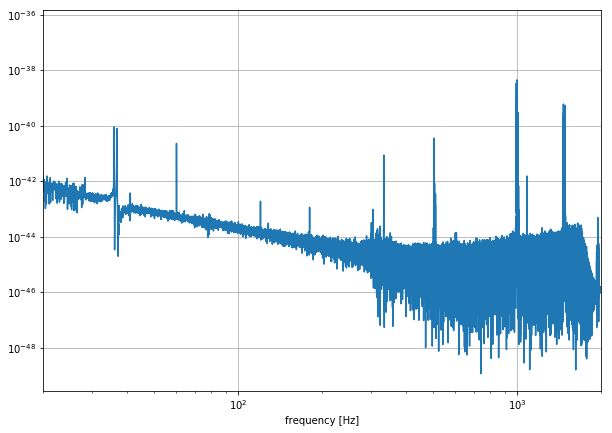

In [9]:
N = 4*fs
fs = event['fs']
dt = 1.0 / fs

norm = 2.0/N
strain_H1_f = np.fft.rfft(strain_H1)
abs_strain_H1_f = norm*np.abs(strain_H1_f)

t_f = np.fft.rfftfreq(len(strain_H1), d = 1./fs)

plt.figure(figsize = (10,7))
plt.loglog(t_f, abs_strain_H1_f**2)
plt.xlim(20, 2000)
plt.xlabel('frequency [Hz]')
plt.grid()
plt.show()

Plotting strain data in the Fourier domain gives us an idea of the frequency content of the data. Here, we visualize the frequency content of the data by plotting the amplitude spectral density, ASD.

The ASDs are the square root of the power spectral densities (PSDs), which are averages of the square of the fast fourier transforms (FFTs) of the data.

They are an estimate of the "strain-equivalent noise" of the detectors versus frequency,
which limit the ability of the detectors to identify GW signals. (There's a signal in these data! For the moment, let's ignore that, and assume it's all noise.)

<span style="color:blue"> <i> 4. mlab.psd (https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.psd.html) gives PSDs. Use this to compute PSDs and take square roots to obtain ASDs. The input data are strain values, and let Fs = fs (which is 4096) and NFFT = 4*fs. (We are dividing the data into NFFT length segments) Plot ASDs of both H1 and L1 data. Label each plot. </i></span> <br><br>
(Hint: Do "PSD, freqs = mlab.psd(data, Fs, NFFT)" to get the PSD values<br>
 Then, plot np.sqrt(PSD) as a function of freqs.)

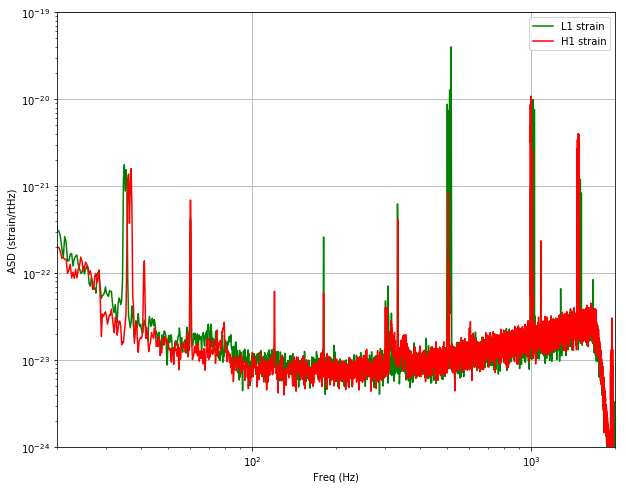

In [10]:
N = 4*fs
fs = event['fs']
dt = 1.0 / fs

Pxx_H1, freqs_H1 = mlab.psd(strain_H1, Fs = fs, NFFT = N)
Pxx_L1, freqs_L1 = mlab.psd(strain_L1, Fs = fs, NFFT = N)

freqs = freqs_H1

plt.figure(figsize=(10,8))
plt.loglog(freqs_L1, np.sqrt(Pxx_L1),'g',label='L1 strain')
plt.loglog(freqs_H1, np.sqrt(Pxx_H1),'r',label='H1 strain')

plt.axis([20, 2000, 1e-24, 1e-19])
plt.grid('on')
plt.ylabel('ASD (strain/rtHz)')
plt.xlabel('Freq (Hz)')
plt.legend()
plt.show()

In the above plot, we only show the data between 20 Hz and 2000 Hz.

You see strong spectral lines in the data; they are all of instrumental origin. However, you can't see the signal in this plot, since it is relatively weak and less than a second long, while this plot averages over 32 seconds of data. So this plot is entirely dominated by instrumental noise.



<br>
Now, let's plot the best-matching gravitational waveform predicted by General Relativity.

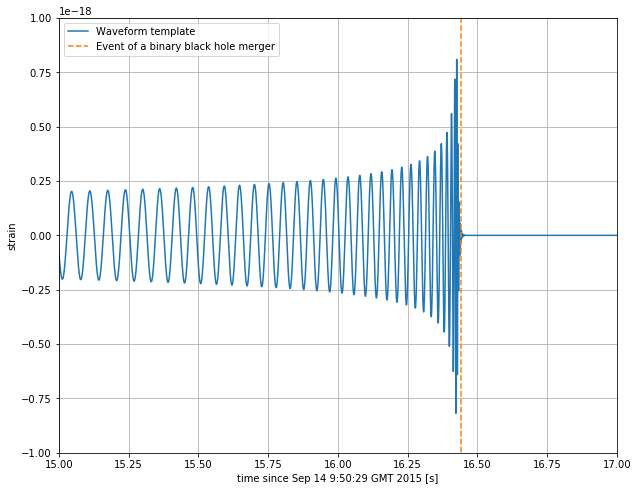

In [11]:
# read in the template and parameters for the theoretical waveform
f_template = h5py.File(fn_template, "r")
template_p, template_c = f_template["template"][...]
time_template = time+(tevent-16)

plt.figure(figsize=(10,8))
plt.plot(time_template,template_p, label = 'Waveform template')
plt.plot(tevent*np.ones(2), [-2.0e-18, 1.e-18], '--', label = 'Event of a binary black hole merger')

plt.xlim(15, 17); plt.ylim(-1.0e-18, 1.0e-18)
plt.xlabel('time since Sep 14 9:50:29 GMT 2015 [s]'); plt.ylabel('strain')
plt.grid('on')
plt.legend()
plt.show()

<br>
Following https://arxiv.org/pdf/1710.04635.pdf, we model the gravitational wave signal by making analogies to electromagnetic waves.

Assume that two masses orbit their common center of mass. The orbiting system emits gravitational waves, which carry energy away from the system, leading to a decay of the orbits, that is, there is an “in-spiral” of the masses.

Starting from an expression that indicates how the orbital frequency changes as the binary system radiates
energy, we can find how the distance between two masses (denoted as $r$) changes with time:

$$ \frac{dr}{dt} = \frac{-\eta N c}{4}\Big( \frac{r_s}{r} \Big)^3 $$

where $r_s$ is the Schwarzschild radius, the distance from the center of a spherically symmetric mass at which the escape speed, calculated from Newtonian mechanics in this case, is equal to the speed of light. For two binary masses, $r_s = 2GM/c^2$. $\eta = m_1 m_2/(m_1 + m_2)^2$ is a dimensionless raio of the masses, and $N$ is a numerical factor which depends on the details of the theory used to derive the result. Here, $\eta = 0.247, N = 6.4, M = 60.5M_{\mathrm{sun}}$.

We can now find the waveform with the following calculational steps:

<b>1.</b> Let $r_i = 1.7r_s$ (initial separation of two masses) and $t_i$ = time_template[64805] (16.26s since Sep 14 9:50:29 GMT 2015). Assume $t_f = 16.4$. Use $10000$ steps, so $\Delta t = (t_f-t_i)/10000$

<b>2.</b> Solve the above differential equation in three different ways:

&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; (1) Analytically: $r(t) = \big[r_i^4 - N\eta r_s^3 c (t-t_i)\big]^{1/4}$

&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; (2) Euler's Method (numerically): Let $f(r) = \frac{dr}{dt}$. Then, $r(t+\Delta t) = \Delta t \cdot f(r)$ for small $\Delta t$.

&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; (3) Runge-Kutta Method (numerically): Let $f(r) = \frac{dr}{dt}$. $k_1 = \Delta t \cdot f(r), k_2 = \Delta t \cdot f(r+\frac{1}{2}k_1)$. Then, $r(t+\Delta t) = r(t) + k_2$ for small $\Delta t$.

&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; Yes, it is silly to solve this DEQ numerically since its analytic solution can be found very easily. But if you have nonlinear equations, (2) and (3) can be very useful.

<b>3.</b> Calculate $r$ for the current time value. ($\Delta t$ should be very small.)

<b>4.</b> Use Kepler's third law to find $w(t)$ (which shows orbital frequency) and calculate $w$ for the current time value.

$$ w^2 = \frac{GM}{r^3} $$.

<b>5.</b> Use that value of $w$ and calculate the interferometer strain signal $h(t)$:

$$ h(t) = \frac{\Delta L_x(t) - \Delta L_y(t)}{L} \propto w^{2/3}\mathrm{cos}(2wt) $$

<b>5.</b> For the next time value, repeat step 3-5 to find $r, w, h$.

<b>6.</b> Stop when $t$ reaches 16.4 ($t_f = 16.4$).

<b>7.</b> Scale $h(t)$ so that $h(t_i)$ = template_p[64805]. (Remember that $t_i$ = time_template[64805].) 

<span style="color:blue"> <i> 5. Solving the given differential equation in three different ways (analytically, using Euler's method, using Runge-Kutta Method), find three different versions of $h(t)$. Then, show how our estimate of the waveform ($h(t)$) matches with the actual waveform ("template_p"); first plot "template_p" as a function of "time_template" and then plot three different versions of $h(t)$ in the same figure. Try different $M = 55M_{\mathrm{sun}}, 60.5M_{\mathrm{sun}}, 65M_{\mathrm{sun}}$ and show that $M = 60.5M_{\mathrm{sun}}$ fits best to the given waveform (for $M = 55M_{\mathrm{sun}}, 65M_{\mathrm{sun}}$, plot $h(t)$ using only the analytic solution. For $M = 60.5M_{\mathrm{sun}}$, try all three methods to plot $h(t)$.) Label all plots. set the x limits of the axes as plt.xlim(ti, 16.45).</i></span> <br>


In [12]:
G = 6.67408e-11
Msun = 1.99e30
c = 2.99792e8

N = 32/5
eta = 0.247

ti = time_template[64805]

In [13]:
# Method 1: Analytic solution
t = np.linspace(ti,16.4, 10000)

def r_func(t, M):
    rs = 2*G*M/(c**2)
    ri = 5.3*rs
    return (ri**4 - N*eta*(rs**3)*c*(t-ti))**(1./4.)

def get_h_analytic(M):
    h_analytic = np.zeros(len(t))
    for i in range(len(t)):

        r = r_func(t[i], M)
        w = np.sqrt(G*M/(r**3))

        h_analytic[i] = w**(2./3.)*np.cos(2*w*(t[i]-ti))
    return h_analytic

In [14]:
# Method 2: Euler's method

M = 60.5*Msun
rs = 2*G*M/(c**2)
ri = 5.3*rs

def drdt(r):
    return -eta*N*c/4*(rs/r)**3

Nstep = 10000
t = np.linspace(ti,16.4, Nstep)
h_Euler = np.zeros(len(t))    

r = ri

for i in range(len(t)):
    
    w = np.sqrt(G*M/(r**3))

    h_Euler[i] = w**(2./3.)*np.cos(2*w*(t[i]-ti))
    
    r += (16.4-ti)/Nstep*drdt(r)
    

In [15]:
# Method 3: Runge-Kutta Method

M = 60.5*Msun
rs = 2*G*M/(c**2)
ri = 5.3*rs

def drdt(r):
    return -eta*N*c/4*(rs/r)**3

Nstep = 10000
t = np.linspace(ti,16.4, Nstep)
h_Runge_Kutta = np.zeros(len(t))    

r = ri

for i in range(len(t)):
    
    w = np.sqrt(G*M/(r**3))

    h_Runge_Kutta[i] = w**(2./3.)*np.cos(2*w*(t[i]-ti))
    
    k1 = (16.4-ti)/Nstep*drdt(r)
    r += (16.4-ti)/Nstep*drdt(r+0.5*k1)
  

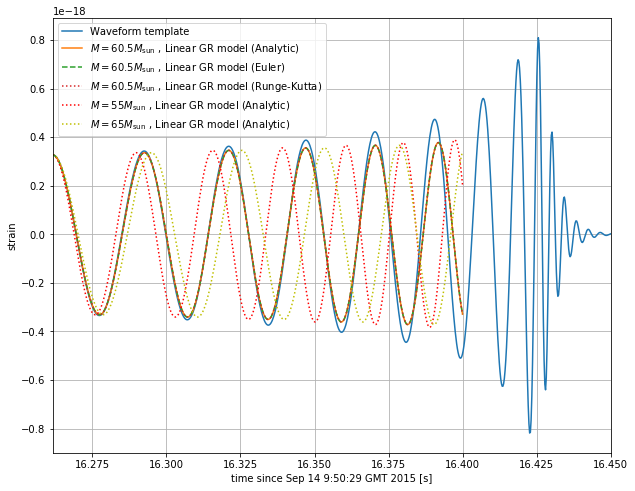

In [16]:
h_analytic = get_h_analytic(60.5*Msun); a_analytic = template_p[64805]/h_analytic[0]
h_analytic_2 = get_h_analytic(55*Msun); a_analytic_2 = template_p[64805]/h_analytic_2[0]
h_analytic_3 = get_h_analytic(65*Msun); a_analytic_3 = template_p[64805]/h_analytic_3[0]
a_Euler = template_p[64805]/h_analytic[0]
a_Runge_Kutta = template_p[64805]/h_analytic[0]

plt.figure(figsize=(10,8))
plt.plot(time_template,template_p, label = 'Waveform template')
plt.xlim(ti, 16.45)
plt.plot(t, h_analytic*a_analytic, label = '$M = 60.5M_\mathrm{sun}$ , Linear GR model (Analytic)')
plt.plot(t, h_Euler*a_Euler, '--', label = '$M = 60.5M_\mathrm{sun}$ , Linear GR model (Euler)')
plt.plot(t, h_Runge_Kutta*a_Runge_Kutta, ':', label = '$M = 60.5M_\mathrm{sun}$ , Linear GR model (Runge-Kutta)')
plt.plot(t, h_analytic_2*a_analytic_2, 'r:', label = '$M = 55M_\mathrm{sun}$ , Linear GR model (Analytic)')
plt.plot(t, h_analytic_3*a_analytic_3, 'y:', label = '$M = 65M_\mathrm{sun}$ , Linear GR model (Analytic)')
plt.xlabel('time since Sep 14 9:50:29 GMT 2015 [s]'); plt.ylabel('strain')
plt.grid('on')
plt.legend()
# plt.savefig("Waveformtemplate.pdf")
plt.show()

You should find that with $M = 60.5M_{\mathrm{sun}}$, $h(t)$ agrees reasonably well with the actual waveform which uses numerical GR. Our estimate breaks down as we get closer to the merger event. 

<br>
From the ASD in Part 4, we can see that noise fluctuations are much larger at low and high frequencies and near spectral lines, reaching a roughly flat ("white") minimum in the band around 80 to 300 Hz.

We can "whiten" the data (dividing it by the noise amplitude spectrum, in the fourier domain), suppressing the extra noise at low frequencies and at the spectral lines, to better see the weak signals in the most sensitive band. Note that only the data are needed in this process.

To get rid of remaining high frequency noise, we will also bandpass the data.

Now, define a function called "whiten" which takes the strain data ("strain"), interpolated psd ("interp_psd"), and dt (1.0 / fs = 1.0 / 4096).

&nbsp; &nbsp; &nbsp; Note:

&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; 1. For L1 and H1, strain = strain_L1 and strain = strain_H1 respectively.

&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; 2. Let Pxx_H1 be the psd values you obtained in Part 4 for H1. Then, interpolate this as "psd_H1 = interp1d(freqs, Pxx_H1)" (https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.interpolate.interp1d.html). psd_H1 is a function; to get the psd values at the needed frequencies (say you have an array "freqs"), you should do psd_H1(freqs).

&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; 3. So "whiten(strain_H1,psd_H1,1.0/fs)" would whiten the strain data for H1.

<span style="color:blue"> <i> 6. Define a function "whiten". Then, whiten the H1 and L1 strain data. (Replace ellipsis) </i></span> <br>

In [17]:
# transform to freq domain, divide by asd, then transform back
def whiten(strain, interp_psd, dt):
    # Given strain data, first transform to frequency domain
    # Use "np.fft.rfftfreq" to get the frequencies and "np.fft.rfft" to get the FFT of the strain
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)
    hf = np.fft.rfft(strain)
    
    # Normalization factor
    norm = 1./np.sqrt(1./(dt*2))
    
    # Divide by the ASD and multiply by the normalization factor
    white_hf = hf / np.sqrt(interp_psd(freqs)) * norm
    
    # Transform back to the time domain using "np.fft.irfft" (Hint: n = len(strain)) 
    # https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.fft.irfft.html
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht   

In [18]:
dt = 1.0 / fs

psd_H1 = interp1d(freqs, Pxx_H1)
psd_L1 = interp1d(freqs, Pxx_L1)

strain_H1_whiten = whiten(strain_H1,psd_H1,dt)
strain_L1_whiten = whiten(strain_L1,psd_L1,dt)


<span style="color:blue"> <i> Remember that the sampling rate ("fs") is 4096 Hz. What is the nyquist frequency? </i></span> <br>
(Note: The data cannot capture frequency content above the Nyquist frequency, but that's OK, because GW150914 only has detectable frequency content in the range 20 Hz - 300 Hz.)

In [19]:
nyq = 0.5*fs

Now, suppress the high frequency noise (no signal there) with some bandpassing. (We bandpass from 43 to 300 Hz, since we are looking for a signal in that frequency band and the detector noise is pretty low there. This will keep power in this frequency range, but suppress power away from this frequency.) We use scipy.signal.butter (https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.signal.butter.html) and scipy.signal.filtfilt (https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.signal.filtfilt.html)

In [20]:
# bandpass filter coefficients 
order = 4
lowcut= 43
highcut= 360
low = lowcut / nyq
high = highcut / nyq

bb, ab = butter(order, [low, high], btype='band')
normalization = np.sqrt((highcut-lowcut)/nyq)
strain_H1_whitenbp = filtfilt(bb, ab, strain_H1_whiten) / normalization
strain_L1_whitenbp = filtfilt(bb, ab, strain_L1_whiten) / normalization

Shift L1 event by 7 ms (Signal arrived 7 ms earlier at L1)

In [21]:
strain_L1_shift = -np.roll(strain_L1_whitenbp,int(0.007*fs))

<span style="color:blue"> <i> Plot "strain_L1_shift" (whitened L1 strain shifted by 7ms) and "strain_H1_whitenbp" (whitened H1 strain) as a function of time. Set "plt.xlim(ti, 16.45); plt.ylim(-10, 10)". Do you see a signal? </i></span> <br>

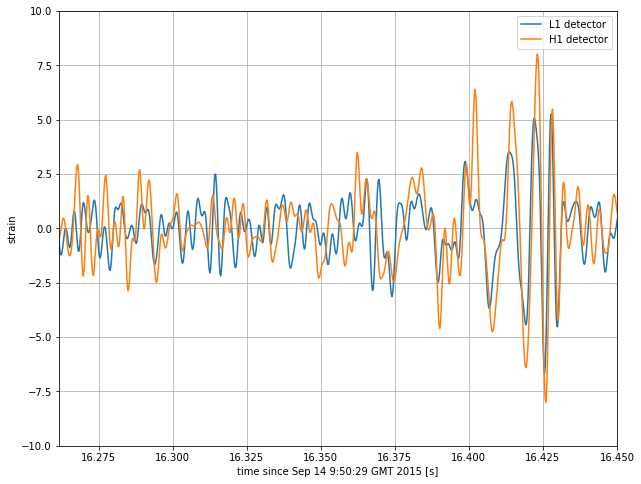

In [22]:
plt.figure(figsize=(10,8))
plt.plot(time,strain_L1_shift, label = 'L1 detector')
plt.plot(time,strain_H1_whitenbp, label = 'H1 detector')

plt.xlim(ti, 16.45); plt.ylim(-10, 10)
plt.xlabel('time since Sep 14 9:50:29 GMT 2015 [s]'); plt.ylabel('strain')
plt.grid('on')
plt.legend()
plt.show()

<br>
The FFT input signal is inherently truncated. This truncation can be modelled as multiplication of an infinite signal with a rectangular window function. In the spectral domain this multiplication becomes convolution of the signal spectrum with the window function spectrum, being of form sin⁡(x)/x. This convolution is the cause of an effect called spectral leakage (https://en.wikipedia.org/wiki/Spectral_leakage)

Hence, spectral leakage is caused by discontinuities in the original, noninteger number of periods in a signal. Windowing the signal with a dedicated window function helps mitigate spectral leakage by reducing the amplitude of the discontinuities at the boundaries

<img src="window.png" width="300" height="150" />

In this project, we use the Blackman window (https://docs.scipy.org/doc/numpy/reference/generated/numpy.blackman.html#numpy.blackman). 

<span style="color:blue"> <i> 7. Recall that in Part 2 we found the FFT of $f(t)$ using np.fft.rfft. Now, define a window function "w = np.blackman(N)" and multiply $f(t)$ by w and do the FFT. $\big($np.fft.rfft(w*f(t))$\big)$. Plot the FFT of $f(t)$ with and without the window function. Set the y-axis as log-scale (plt.semilogy). Show that windowing reduces spectral leakage.  </i></span> <br>

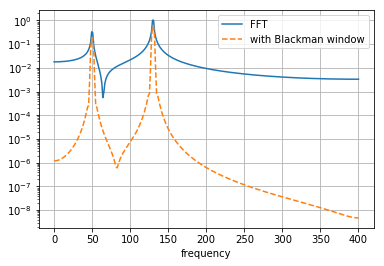

In [23]:
# Number of samples
N = 600
# sampling rate
fs = 800.0
# sample spacing
dt = 1.0 / fs

t = (1 / fs_example * np.arange(N))

def f(t, a1, a2, w1, w2):
    return a1*np.sin(2.0*np.pi*w1*t) + a2*np.sin(2.0*np.pi*w2*t)
    
y = f(t, 0.5, 1.6, 50, 130)

norm = 2.0/N
yf = np.fft.rfft(y)
abs_yf = norm*np.abs(yf)

xf = np.fft.rfftfreq(len(y), d = 1./fs)

w = np.blackman(N)
ywf = np.fft.rfft(y*w)
abs_ywf = norm*np.abs(ywf)

plt.semilogy(xf, abs_yf, label = 'FFT')
plt.semilogy(xf, abs_ywf, '--', label = 'with Blackman window')

plt.xlabel('frequency')
plt.legend()
plt.grid()
plt.show()

<br>
Matched filtering is the optimal way to find a known signal buried in stationary, Gaussian noise. It is the standard technique used by the gravitational wave community to find GW signals from compact binary mergers in noisy detector data. LIGO scientists use matched filtering to find such "hidden" signals. A matched filter works by compressing the entire signal into one time bin (by convention, the "end time" of the waveform).

Here, we use only one template (the one identified in the full search as being a good match to the data). Assuming that the data around this event is fairly Gaussian and stationary, we'll use this simple method to identify the signal (matching the template) in our 32 second stretch of data. 


<span style="color:blue"> <i> 8. Do the matched filtering. First, start with the L1 strain data. </i></span> <br>

In [24]:
# To calculate the PSD of the data, choose an overlap and a window 
fs = event['fs']
dt = 1.0 / fs
NFFT = 4*fs
psd_window = np.blackman(NFFT)
# and a 50% overlap:
NOVL = NFFT/2

# Complex waveform template
template = (template_p + template_c*1.j) 

# the length and sampling rate of the template MUST match that of the data.
datafreq = np.fft.fftfreq(template.size, d = 1./fs)
df = np.abs(datafreq[1] - datafreq[0])



<span style="color:blue"> <i> Window the data. (Replace ellipsis in the cell below) </i></span> <br>

1. Define the window: "np.blackman(template.size)"

2. Do the FFT of the template with window using "np.fft.fft": multiply "template" by "dwindow" and then do FFT. The normalization factor is "1/fs" (i.e. multiply the FFT of the template by 1/fs)

3. Do the FFT of the L1 strain data with window using "np.fft.fft": multiply the L1 strain data by "dwindow" and then do FFT. The normalization factor is "1/fs" (i.e. multiply the FFT of the template by 1/fs)

In [25]:
# window the data (Replace ellipsis)

# 1. Define the window
dwindow = np.blackman(template.size)

# 2. Do the FFT of the template (with dwindow)
template_fft = np.fft.fft(template*dwindow) / fs

# 3. Take the Fourier Transform (FFT) of the data (with dwindow)
data = strain_L1.copy()
data_fft = np.fft.fft(data*dwindow) / fs


<span style="color:blue"> <i> Plot the blackman window as a function of time. Do you think using this window is useful in our analysis? Note that the merger event occurred around 16s since Sep 14 9:50:29 GMT 2015, and the data stretches over 32s.  </i></span> <br>

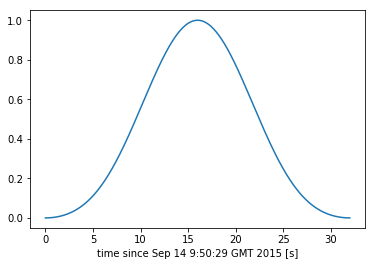

In [26]:
plt.plot(time, dwindow)
plt.xlabel('time since Sep 14 9:50:29 GMT 2015 [s]')
plt.show()


<span style="color:blue"> <i> Plot the FFT of the template with and without the window (as a function of frequency). Only use positive frequencies. Plot the squared magnitude of the FFT (power spectrum). Label all plots. Set the range of x-axis between 5 and 2000. Plot both axes in log scale. </i></span> <br>

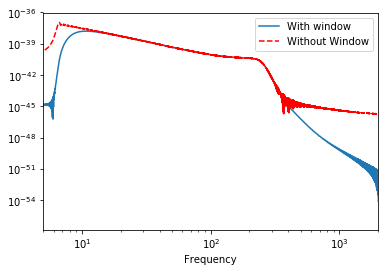

In [27]:
datafreq = np.fft.fftfreq(template.size, d = 1./fs)
template_fft = np.fft.fft(template*dwindow) / fs
template_fft2 = np.fft.fft(template) / fs

plt.loglog(datafreq, np.abs(template_fft)**2, label = 'With window')
plt.loglog(datafreq, np.abs(template_fft2)**2, 'r--', label = 'Without Window')

plt.xlim(5, 2000)
plt.xlabel('Frequency')
plt.legend()
plt.show()


Next, we need an estimate of the noise power in each FFT bin.

In [28]:
# First, calculate the PSD of the data.  Also use an overlap, and window:
data_psd, freqs = mlab.psd(data, Fs = fs, NFFT = NFFT, window=psd_window, noverlap=NOVL)
# Interpolate to get the PSD values at the needed frequencies. This defines the noise power in each frequency bin.
power_vec = np.interp(np.abs(datafreq), freqs, data_psd)


<span style="color:blue"> <i> Plot the noise power spectral density (defined by "power_vec"). Set the range of x-axis between 10 and 2000. Plot both axes in log scale. </i></span> <br>

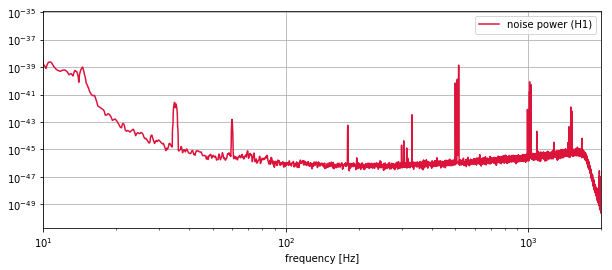

In [29]:
plt.figure(figsize=(10,4))
plt.loglog(datafreq, power_vec, color = 'crimson', label = 'noise power (H1)')
plt.xlim(10, 2000)
plt.grid('on')
plt.xlabel('frequency [Hz]')
plt.legend()
plt.show()

<span style="color:blue"> <i> Calculate the matched filter output in the time domain. (Replace ellipsis in the cell below) </i></span> <br>

<img src="optimalfitering.png" width="500" height="250" />

1. Multiply the Fourier Space template and data, and divide by the noise power in each frequency bin: i.e. Multiply the FFT of the data with the conjugate (using ".conjugate()") of the FFT of the template and divide by the noise power ("power_vec")

2. Taking the Inverse Fourier Transform (IFFT) of the filter output (take it back to the time domain): i.e. Take the inverse FFT (using np.fft.ifft) of the step 1 output and multiply by the factor "2*fs"

Hence, the result will be plotted as a function of time off-set between the template and the data:

In [30]:
# 1. Multiply the Fourier Space template and data, and divide by the noise power in each frequency bin.
optimal = data_fft * template_fft.conjugate() / power_vec

# 2. Taking the Inverse Fourier Transform (IFFT) of the filter output (take it back to the time domain)
optimal_time = 2*np.fft.ifft(optimal)*fs

<span style="color:blue"> <i> Normalize the matched filter output. (Replace ellipsis in the cell below) </i></span> <br>

1. Find $\sigma = \sqrt{\big<\frac{\tilde{h}(f)\tilde{h}^*(f)}{S_n(f)}\big>}$
(Hint: First multiply the FFT of the template by its conjugate (using ".conjugate()") and then divide by the noise PSD. Basically you did $\frac{\tilde{h}(f)\tilde{h}^*(f)}{S_n(f)}$. You have an array then (each array element correspond to each element in the frequency array "datafreq" you defined earlier). Now, sum array elements and multiply by "df" which you defined earlier.

2. Normalize the matched filter output so that we expect a value of 1 at times of just noise: i.e. Divide the absolute value of "optimal_time" by sigma.

In [31]:
# 1. Find $\sigma$
sigmasq = (template_fft * template_fft.conjugate() / power_vec).sum() * df
sigma = np.sqrt(sigmasq.real)

# 2. Normalize the matched filter output so that we expect a value of 1 at times of just noise
SNR = abs(optimal_time)/sigma


<span style="color:blue"> <i> Apply time offset, phase to template. Finally, whiten the template and band-pass it. (All routine given - nothing to do here, just run the cell.) </i></span> <br>

In [32]:
# shift the SNR vector by the template length so that the peak is at the END of the template
peaksample = int(data.size / 2)  # location of peak in the template
SNR_complex = optimal_time/sigma
SNR_complex = np.roll(SNR_complex,peaksample)
SNR = abs(SNR_complex)

# apply time offset, phase to template
# find the time and SNR value at maximum:
indmax = np.argmax(SNR)
timemax = time[indmax]
SNRmax = SNR[indmax]

d_eff = sigma / SNRmax
# Calculate optimal horizon distnace
horizon = sigma/8

# Extract time offset and phase at peak
phase = np.angle(SNR_complex[indmax])
offset = (indmax-peaksample)

# apply time offset, phase, and d_eff to template 
template_phaseshifted = np.real(template*np.exp(1j*phase))    # phase shift the template
template_rolled = np.roll(template_phaseshifted,offset) / d_eff  # Apply time offset and scale amplitude

# Whiten and band-pass the template for plotting
template_whitened = whiten(template_rolled,interp1d(freqs, data_psd),dt)  # whiten the template
template_match = filtfilt(bb, ab, template_whitened) / normalization # Band-pass the template


<span style="color:blue"> <i> Plot the original, phase-shifted template ("template_rolled") and the whitened template ("template_whitened"). Show the plot between the time range (15.6, 16.45) since Sep 14 9:50:29 GMT 2015. You will see that the waveform before ~ 16.3s is largely suppressed. That is because we divide the FFT of the template by the noise PSD in the Fourier space during whitening. Now, calculate FFT(template)/Noise PSD$^{1/2}$ and plot it as a function of frequency in the log-log plot. Set the x-axis range between 5 and 2000 Hz.</i></span> <br>

In [33]:
template_whitened = whiten(template_rolled,interp1d(freqs, data_psd),dt)

Nt = len(template_rolled)
freqs_t = np.fft.rfftfreq(Nt, dt)
hf = np.fft.rfft(template_rolled)
norm = 1./np.sqrt(1./(dt*2))

white_hf = hf / np.sqrt(interp1d(freqs, data_psd)(freqs_t)) * norm

In [34]:
a1 = []
for i in range(len(time)):
    if i != 0 and i != 131071 and (template_rolled[i+1] - template_rolled[i]) < 0 and (template_rolled[i-1] - template_rolled[i]) < 0:
        a1.append(i)
        
tt = []
w = []
for i in range(len(a1))[:165]:
    tt.append((time[a1[i]] + time[a1[i+1]])/2.)
    w.append(1/(time[a1[i+1]] - time[a1[i]]))

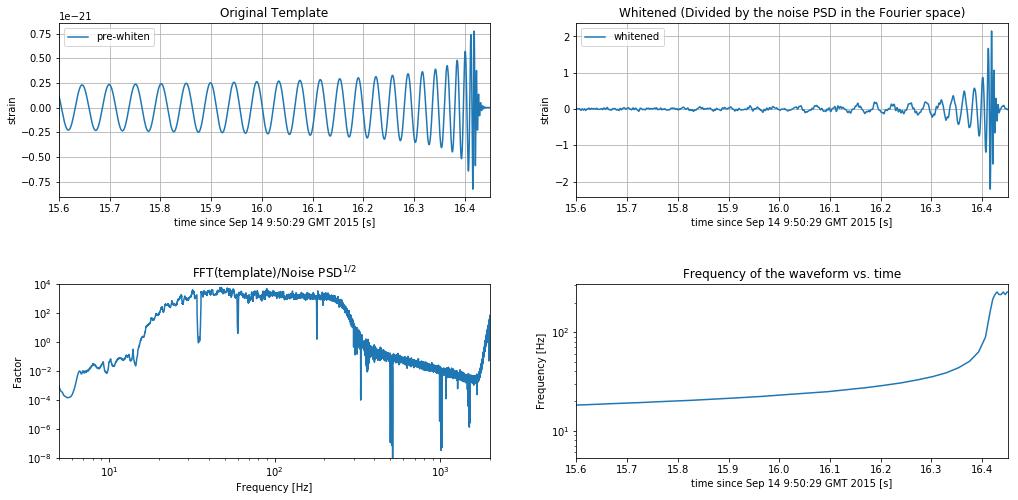

In [35]:
fig, axes = plt.subplots(2,2,figsize=(17,8))
fig.subplots_adjust(wspace=.2, hspace=.5)
ax = axes[0,0]
ax.plot(time,template_rolled, label = 'pre-whiten')
ax.set_xlim(15.6, 16.45)
ax.grid('on')
ax.set_xlabel('time since Sep 14 9:50:29 GMT 2015 [s]')
ax.set_ylabel('strain')
ax.legend(loc='upper left')
ax.set_title("Original Template")

ax = axes[0,1]
ax.plot(time,template_whitened, label = 'whitened')
ax.set_xlim(15.6, 16.45)
ax.grid('on')
ax.set_xlabel('time since Sep 14 9:50:29 GMT 2015 [s]')
ax.set_ylabel('strain')
ax.legend(loc='upper left')
ax.set_title("Whitened (Divided by the noise PSD in the Fourier space)")

ax = axes[1,0]
ax.loglog(freqs_t, np.abs(white_hf)**2)
ax.set_xlim(5, 2000)
ax.set_ylim(1.e-8, 1.e4)
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Factor')
ax.set_title("FFT(template)/Noise PSD$^{1/2}$")

ax = axes[1,1]
ax.semilogy(tt, w)
ax.set_xlim(15.6, 16.45)
ax.set_xlabel('time since Sep 14 9:50:29 GMT 2015 [s]')
ax.set_ylabel('Frequency [Hz]')
ax.set_title("Frequency of the waveform vs. time")

plt.show()

<span style="color:blue"> <i> Plot SNR as a function of time. (Remember that the GW signal arrived 7 ms earlier at L1. So shift the L1 time accordingly - this is done conventionally.)  Set plt.xlim(16.3, 16.5). </i></span> <br>

In [36]:
# Shift L1 event by 7 ms (Signal arrived 7 ms earlier at L1)
SNR_shift = np.roll(SNR,int(0.007*fs))

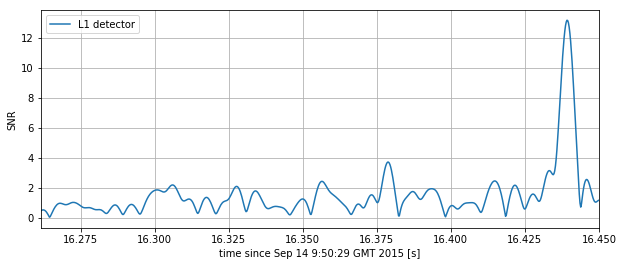

In [37]:
plt.figure(figsize=(10,4))
plt.plot(time, SNR_shift, label = 'L1 detector')
plt.grid('on')
plt.ylabel('SNR')
plt.xlim(ti, 16.45)
plt.grid('on')
plt.xlabel('time since Sep 14 9:50:29 GMT 2015 [s]')
plt.legend()
plt.show()

In [38]:
# Shift L1 event by 7 ms (Signal arrived 7 ms earlier at L1)
template_match_shift_L1 = -np.roll(template_match,int(0.007*fs))

<span style="color:blue"> <i> At what time does SNR peak? Print the result. (Remember that the GW signal arrived 7 ms earlier at L1. So shift the L1 time accordingly - this is done conventionally.) </i></span> <br>

In [39]:
L1_timemax = timemax + 0.007
print(L1_timemax, "seconds after Sep 14 9:50:29 GMT 2015")

16.4393730469 seconds after Sep 14 9:50:29 GMT 2015


<span style="color:blue"> <i> First, plot the whitened strain data (from Part 6) as a function of time. Then, plot the matched waveform ("template_match_shift_L1") in the same figure. Show that the whitened strain data match well to the waveform predicted by GR. </i></span> <br>

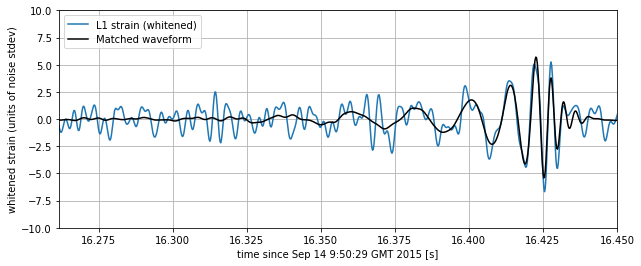

In [40]:
plt.figure(figsize=(10,4))
plt.plot(time,strain_L1_shift, label = 'L1 strain (whitened)')
plt.plot(time,template_match_shift_L1,'k',label='Matched waveform')
plt.ylim([-10,10])
plt.xlim(ti, 16.45)
plt.grid('on')
plt.xlabel('time since Sep 14 9:50:29 GMT 2015 [s]')
plt.ylabel('whitened strain (units of noise stdev)')
plt.legend(loc='upper left')
plt.show()

<br>
<span style="color:blue"> <i> 9. Repeat Part 8 for the H1 strain data and do: 1. Plot SNR vs. time, 2. plot the whitened strain data and matched waveform vs. time, 3. find the time at which SNR peaked. </i></span> <br>

In [41]:
data = strain_H1.copy()
data_fft = np.fft.fft(data*dwindow) / fs

data_psd, freqs = mlab.psd(data, Fs = fs, NFFT = NFFT, window=psd_window, noverlap=NOVL)

power_vec = np.interp(np.abs(datafreq), freqs, data_psd)

optimal = data_fft * template_fft.conjugate() / power_vec
optimal_time = 2*np.fft.ifft(optimal)*fs

sigmasq = (template_fft * template_fft.conjugate() / power_vec).sum() * df
sigma = np.sqrt(sigmasq.real)

SNR = abs(optimal_time)/sigma

# shift the SNR vector by the template length so that the peak is at the END of the template
peaksample = int(data.size / 2)  # location of peak in the template
SNR_complex = optimal_time/sigma
SNR_complex = np.roll(SNR_complex,peaksample)
SNR = abs(SNR_complex)

# apply time offset, phase to template
# find the time and SNR value at maximum:
indmax = np.argmax(SNR)
timemax = time[indmax]
SNRmax = SNR[indmax]

d_eff = sigma / SNRmax
# Calculate optimal horizon distnace
horizon = sigma/8

# Extract time offset and phase at peak
phase = np.angle(SNR_complex[indmax])
offset = (indmax-peaksample)
template_phaseshifted = np.real(template*np.exp(1j*phase))    # phase shift the template
template_rolled = np.roll(template_phaseshifted,offset) / d_eff  # Apply time offset and scale amplitude

template_whitened = whiten(template_rolled,interp1d(freqs, data_psd),dt)  # whiten the template
template_match_H1 = filtfilt(bb, ab, template_whitened) / normalization # Band-pass the template


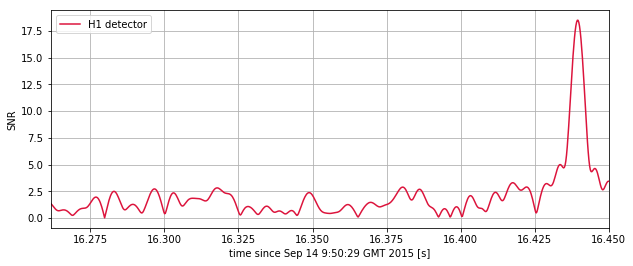

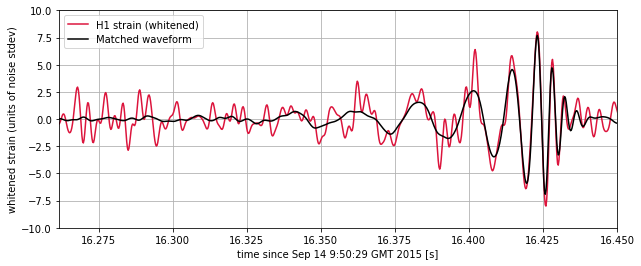

In [42]:
plt.figure(figsize=(10,4))
plt.plot(time, SNR, color = 'crimson', label = 'H1 detector')
plt.grid('on')
plt.ylabel('SNR')
plt.xlim(ti, 16.45)
plt.grid('on')
plt.xlabel('time since Sep 14 9:50:29 GMT 2015 [s]')
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(time,strain_H1_whitenbp, color = 'crimson', label = 'H1 strain (whitened)')
plt.plot(time,template_match_H1,'k',label='Matched waveform')
plt.ylim([-10,10])
plt.xlim(ti, 16.45)
plt.grid('on')
plt.xlabel('time since Sep 14 9:50:29 GMT 2015 [s]')
plt.ylabel('whitened strain (units of noise stdev)')
plt.legend(loc='upper left')
plt.show()

In [43]:
H1_timemax = timemax
print(H1_timemax, "seconds after Sep 14 9:50:29 GMT 2015")

16.439453125 seconds after Sep 14 9:50:29 GMT 2015


<br>
<span style="color:blue"> <i> 10. First, compare the SNR peak time for both H1 and L1 data. (Print the results) Then, plot the whitened L1 and H1 strain in the same plot. Plot the waveform matched to the H1 strain data in the same plot as well.  </i></span> <br>

In [44]:
H1_timemax = timemax
print('Peak SNR time:')
print("L1: ", L1_timemax, "seconds after Sep 14 9:50:29 GMT 2015")
print("H1: ", H1_timemax, "seconds after Sep 14 9:50:29 GMT 2015")

Peak SNR time:
L1:  16.4393730469 seconds after Sep 14 9:50:29 GMT 2015
H1:  16.439453125 seconds after Sep 14 9:50:29 GMT 2015


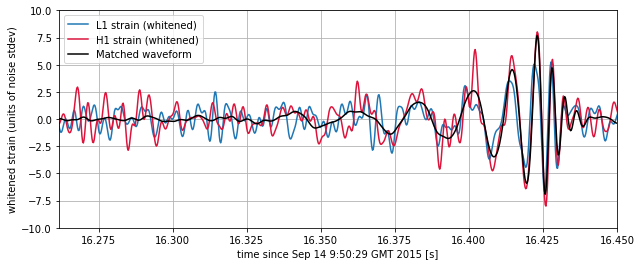

In [45]:
plt.figure(figsize=(10,4))
plt.plot(time,strain_L1_shift, label = 'L1 strain (whitened)')
plt.plot(time,strain_H1_whitenbp, color = 'crimson', label = 'H1 strain (whitened)')
plt.plot(time,template_match_H1,'k',label='Matched waveform')
plt.ylim([-10,10])
plt.xlim(ti, 16.45)
plt.grid('on')
plt.xlabel('time since Sep 14 9:50:29 GMT 2015 [s]')
plt.ylabel('whitened strain (units of noise stdev)')
plt.legend(loc='upper left')
plt.show()

So we conclude that the whitened strain data match well to the waveform predicted by General Relativity; we have detected the gravitational wave predicted by GR!

<br>
<b>Extra (all the routine given; just run the cell!):</b>

Make wav (sound) files from the filtered, downsampled data, +-2s around the event.

In [512]:
eventname = 'GW150914' 

Pxx = (1.e-22*(18./(0.1+freqs))**2)**2+0.7e-23**2+((freqs/2000.)*4.e-23)**2
psd_smooth = interp1d(freqs, Pxx)

template_offset = 16.

# function to keep the data within integer limits, and write to wavfile:
def write_wavfile(filename,fs,data):
    d = np.int16(data/np.max(np.abs(data)) * 32767 * 0.9)
    wavfile.write(filename,int(fs), d)

deltat_sound = 2.                     # seconds around the event

# index into the strain time series for this time interval:
indxd = np.where((time >= tevent-deltat_sound) & (time < tevent+deltat_sound))

# write the files:
write_wavfile(eventname+"_H1_whitenbp.wav",int(fs), strain_H1_whitenbp[indxd])
write_wavfile(eventname+"_L1_whitenbp.wav",int(fs), strain_L1_whitenbp[indxd])

# re-whiten the template using the smoothed PSD; it sounds better!
template_p_smooth = whiten(template_p,psd_smooth,dt)

# and the template, sooming in on [-3,+1] seconds around the merger:
indxt = np.where((time >= (time[0]+template_offset-deltat_sound)) & (time < (time[0]+template_offset+deltat_sound)))
write_wavfile(eventname+"_template_whiten.wav",int(fs), template_p_smooth[indxt])

With good headphones, you may be able to hear a faint thump in the middle; that's our signal!

In [514]:
fna = eventname+"_template_whiten.wav"
print(fna)
Audio(fna)

GW150914_template_whiten.wav


In [515]:
fna = eventname+"_H1_whitenbp.wav"
print(fna)
Audio(fna)

GW150914_H1_whitenbp.wav


***

## To Submit
Execute the following cell to submit.
If you make changes, execute the cell again to resubmit the final copy of the notebook, they do not get updated automatically.<br>
__We recommend that all the above cells should be executed (their output visible) in the notebook at the time of submission.__ <br>
Only the final submission before the deadline will be graded. 


In [ ]:
_ = ok.submit()